# EE219 Project 3

### Team members:
* **Yin Fei**

* **Yichen Wu** 504294181 *wyc20020111@ucla.edu*

* **Siyuan Chen** 405024391

* **sdfsd**

### Required Packages:
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2
pandas v0.22.0

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
r_data = pd.read_csv('data/ratings.csv', header=0, usecols=[0, 1, 2])
print(r_data.head())
R = r_data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0).values
print("(number of users, number of rated movies): ", R.shape)


   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0
(number of users, number of rated movies):  (671, 9066)


#### Question 1

In [2]:
# Question 1
user_count = R.shape[0]
movie_count = R.shape[1]
max_rating_count = user_count*movie_count
rating_count = r_data.size/3
sparsity = rating_count*1.0/max_rating_count
print("Matrix sparsity = %0.4f" % sparsity)

Matrix sparsity = 0.0164


#### Question 2

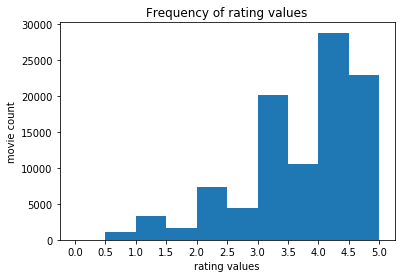

In [10]:
# Question 2
plt.figure()
ax = plt.subplot(111)
ratings = r_data.rating.tolist()
xrange = np.arange(0, 5.5, 0.5)
ax.hist(ratings, bins=xrange)
ax.set_xticks(xrange)
ax.set_title("Frequency of rating values")
ax.set_xlabel("rating values")
ax.set_ylabel("movie count")
plt.show()

#### Question 3

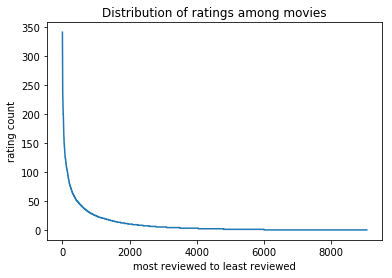

In [9]:
# Question 3
plt.figure()
movie_rating_count = np.count_nonzero(R, axis=0)
sorted_mrc = sorted(movie_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(movie_rating_count)), sorted_mrc, '-')
ax.set_title("Distribution of ratings among movies")
ax.set_xlabel("most reviewed to least reviewed")
ax.set_ylabel("rating count")
plt.show()

#### Question 4

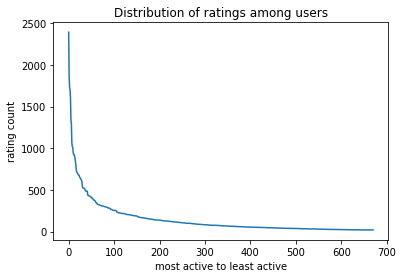

In [11]:
# Question 4
plt.figure()
user_rating_count = np.count_nonzero(R, axis=1)
sorted_urc = sorted(user_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(user_rating_count)), sorted_urc, '-')
ax.set_title("Distribution of ratings among users")
ax.set_xlabel("most active to least active")
ax.set_ylabel("rating count")
plt.show()

#### Question 5
ToDo: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

#### Question 6

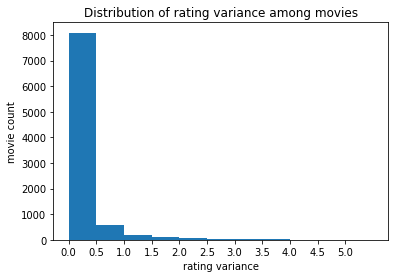

In [13]:
# Question 6
plt.figure()
ax = plt.subplot(111)
movie_var = np.var(R, axis=0)
var_range = np.arange(min(movie_var), max(movie_var)+0.5, 0.5)
ax.hist(movie_var, bins=var_range)
ax.set_xticks(xrange)
ax.set_title("Distribution of rating variance among movies")
ax.set_xlabel("rating variance")
ax.set_ylabel("movie count")
plt.show()